In [9]:
import os
from functools import reduce
from typing import List
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import numpy as np
import pyspark
import pyspark.sql.functions as f
from matplotlib.axes import Axes
from pyspark.sql import DataFrame
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col
from pyspark.sql.types import *
import re

# Если hadoop_home уже настроен это трока не нужна
os.environ['HADOOP_HOME'] = r"D:\Programms\Spark\spark-2.4.4-bin-hadoop2.7"

conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

sqlContext = SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=appName, master=local) created by __init__ at <ipython-input-4-a1a8c406982d>:21 

In [5]:
segment_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\EXPERIAN_CONSUMER_VIEW_SEGMENT_143"
info_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\REF_SVOD_EXPERIAN_MEASURES_MAPPING.gz"

segment_header_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\seg_col_names.txt"
info_header_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\measures_mapping_col_names.txt"

segment_count = 0

In [33]:
def load_main_column_names(col_names_file_name: str) -> List:
    """
    get only important column names
    :param: colNamesFileName (str): name of file with column names
    :return: List: list of important column names
    """
    res = open(col_names_file_name, "r").read().splitlines()
    return res[3:]


def load_header_names(header_file_name: str) -> StructType:
    """
    get column names scheme from file
    :param: headerFileName: name of file with column names
    :return: column names scheme
    """
    file = open(header_file_name, "r").read().splitlines()
    res = [StructField(x, StringType(), True) for x in file]
    return StructType(res)


def load_data_frame(data_file_name: str, header_scheme: StructType) -> DataFrame:
    """
    load dataframe from file
    :param data_file_name: file name of data
    :param header_scheme: column names for chosen dataframe
    :return: loaded dataframe
    """
    df = sqlContext.read.csv(data_file_name, header='false', schema=header_scheme, sep='|')
    return df


def get_columns_with_null(col_names: List, segment_df: DataFrame, info_df: DataFrame) -> str:
    """
    get column names that contain null values(WORK IN PROGRESS)
    :param col_names: names of column that are checked for a null values
    :param segment_df: dataframe that is checked for a null values
    :param info_df: dataframe with availiable values in column
    :return: string with all column names with null value
    """
    res = ""
    for x in col_names:
        cols_values_in_seg = segment_df.select(x).distinct().selectExpr(x + " as vals")

        availiable_cols_values = info_df.select("VALUES_SVOD_TEXT").filter(
            info_df["CONSUMER_VIEW_FIELDS"] == x).distinct().selectExpr("VALUES_SVOD_TEXT as vals")

        if cols_values_in_seg.join(availiable_cols_values, ["vals"], 'leftanti').count() == 1:
            res += x + "\n"
    return res


def get_amount_of_records_with_null(segment_df: DataFrame, column_to_check: List = None) -> int:
    """
    get Amount Of Records With Null value
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: amount of records with null
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check
    return segment_df.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in columns))).count()


def get_amount_of_records_with_null_for_each_column(segment_df: DataFrame, column_to_check: List = None) -> DataFrame:
    """
    get Amount Of Records With Null value for each column
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: dataframe with amount of records with null for each column
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check

    col_nulls = segment_df.select([count(when(col(c).isNull(), c)).alias(c) for c in columns])
    return col_nulls


def get_percent_of_records_with_null_for_each_column(segment_df: DataFrame, column_to_check: List = None) -> DataFrame:
    """
    get percent Of Records With Null value for each column
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: dataframe with percent of records with null for each column
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check
    segment_count = segment_df.count()

    col_nulls_proc = segment_df.select(
        [(count(when(col(c).isNull(), c)) / segment_count).alias(c) for c in columns])
    return col_nulls_proc


def get_null_distribution_in_row(segment_df: DataFrame, column_to_check: List = None) -> DataFrame:
    """
    get null count|amount of rows with that null count dataframe
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: dataframe with null count|amount of rows with that null count
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check

    null_count_df = segment_df.select(
        sum([segment_df[col].isNull().cast(IntegerType()) for col in columns]).alias('null_count'))

    null_count_df.show()
    return null_count_df.groupBy('null_count').count().orderBy('null_count')


def get_legitime_none_and_unknown(col_names: List, segment_df: DataFrame, info_df: DataFrame) -> (str, str, str):
    """
    get column names that have nulls, can have nulls, can have unknown values
    :param col_names: column names to check
    :param segment_df: dataframe with values
    :param info_df: dataframe with info about values in segment_df
    :return: column names that have nulls, can have nulls, can have unknown values
    """
    have_none = ""
    legitime_none = ""
    unknown = ""

    for x in col_names:
        cols_values_in_seg = segment_df.select(x).distinct().selectExpr(x + " as vals")
#         cols_values_in_seg.show()
        availiable_cols_values = info_df.select("VALUES_SVOD_TEXT").filter(
            info_df["CONSUMER_VIEW_FIELDS"] == x).distinct().selectExpr("VALUES_SVOD_TEXT as vals")
#         availiable_cols_values.show()

        in_seg = cols_values_in_seg.take(cols_values_in_seg.count())
        avail = availiable_cols_values.take(cols_values_in_seg.count())
        
        in_seg_vals = []
        for v in in_seg:
            in_seg_vals.append(v.asDict()["vals"])
            
        avail_vals= []
        for v in avail:
            avail_vals.append(v.asDict()["vals"])
        
    
        if None in in_seg_vals:
            print("IN-SEG")
            have_none += x+"\n"
   
        if None in avail_vals:
            print("AVAIL")
            legitime_none += x+"\n"

        if "Unknown" in avail_vals or "unknown" in avail_vals \
            or r"\Null" in avail_vals or "Unknown " in avail_vals or "Unknown or not scored " in avail_vals :
            print("UNK")
            unknown += x+"\n"
        
        print(in_seg_vals, avail_vals)
    return have_none, legitime_none, unknown


In [53]:
col_names = load_main_column_names(segment_header_file)

segment_df = load_data_frame(r"D:\My_Google_Disk\University\BiQuants\segmentData\EXPERIAN_CONSUMER_VIEW_SEGMENT_146", load_header_names(segment_header_file))
info_df = load_data_frame(info_file, load_header_names(info_header_file))

res = get_legitime_none_and_unknown(col_names, segment_df, info_df)


['High', 'Low', 'Medium'] ['High', 'Low', 'Medium']
IN-SEG
AVAIL
UNK
['\\Null', None, 'Likely', 'Unlikely', 'Highly Likely'] ['\\Null', None, 'Likely', 'Unlikely', 'Highly Likely']
IN-SEG
UNK
[None, 'Unknown', 'Yes'] ['Unknown', 'Yes']
IN-SEG
UNK
['unknown', None, 'yes'] ['unknown', 'yes']
IN-SEG
[None, 'No', 'Yes'] ['No', 'Yes']
IN-SEG
UNK
[None, 'Yes ', 'Unknown'] ['Yes ', 'Unknown']
IN-SEG
['High', 'Low', None, 'Medium'] ['High', 'Low', 'Medium']
IN-SEG
AVAIL
UNK
[None, 'Female', 'Unknown', 'Male'] [None, 'Female', 'Unknown', 'Male/Female Pair (Only in Enrichment)']
IN-SEG
['High', 'Low', None, 'Medium'] ['High', 'Low', 'Medium']
IN-SEG
['High', 'Low', None, 'Medium'] ['High', 'Low', 'Medium']
IN-SEG
AVAIL
UNK
['Grad Degree - Extremely Likely', 'Grad Degree - Likely', 'Bach Degree - Extremely Likely', 'HS Diploma - Likely', None, 'Less than HS Diploma - Ex Like', 'Some College - Likely', 'Unknown', 'Some College -Extremely Likely', 'HS Diploma - Extremely Likely', 'Less than HS Dipl

In [59]:
fw = open("seg146CanHaveNullColumnNames.txt", "w")
fw.write(res[1])
fw.close()

In [34]:
fw = open("out.txt", "w")
col_names = load_main_column_names(segment_header_file)

segment_df = load_data_frame(segment_file, load_header_names(segment_header_file))

info_df = load_data_frame(info_file, load_header_names(info_header_file))
nullCount = get_amount_of_records_with_null(segment_df, col_names)
get_amount_of_records_with_null_for_each_column(segment_df, col_names).coalesce(1).write.save("amount",
                                                                                              format="csv",
                                                                                              delimiter="|")
get_percent_of_records_with_null_for_each_column(segment_df, col_names, segment_count).coalesce(1).write.save("percent",
                                                                                               format="csv",
                                                                                               delimiter="|")

get_null_distribution_in_row(segment_df, col_names).coalesce(1).write.save("SegNullDist", format="csv",
                                                                           delimiter="|")

res = get_columns_with_null(col_names, segment_df, info_df)
fw.write(res)

In [51]:
def get_plot_vals_for_nulls_rows(file_name: str) -> (List, List):
    """
    function to get values from Nulls-RowsCount file
    :param file_name: name of Nulls-RowsCount file
    :return: nulls count and amount of records with such null count
    """
    nulls = []
    count = []
    f = open(file_name)
    for x in f.read().splitlines():
        x, y = x.split('|')
        nulls.append(int(x))
        count.append(int(y))
    return nulls, count

def autolabel(ax, rects, is_float=True):
        """
        Attach a text label above each bar in *rects*, displaying its height.
        :param ax: Axes to draw info on
        :param rects: bars of plot to draw labels on
        :param is_float: if values on plot are float values(for normalized values for example)
        :return:
        """
        alls = []
        for rect in rects:
            height = rect.get_height()
            pattern = '{0:.2f}' if is_float else '{}'
            ax.annotate(pattern.format(height if is_float else int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

            
def show_plots_for_all_files(ax: Axes, file_names: List, nums_to_norm: List=None):
    """
    function to represent all Nulls-RowsCount files on a one plot (Very Strange function)
    :param ax: Axes to draw info on
    :param file_names: ame of Nulls-RowsCount files
    :return: None
    """
    plots_count = len(file_names)
    bar_width = 1/plots_count
    rec = []
    max_nulls_len_list = 0
    delta = bar_width if plots_count>1 else 0
    for i in range(len(file_names)):
        nulls, count = get_plot_vals_for_nulls_rows(file_names[i])
        norm = 1
        if nums_to_norm is not None:
            norm = nums_to_norm[i]
        if max(nulls) > max_nulls_len_list:
            max_nulls_len_list = max(nulls)
#         lbl ="seg" + re.findall('(\d+)', file_names[i])[0]
        rec.append(ax.bar(np.array(nulls)+i*bar_width-delta, np.array(count)/float(norm),  width=bar_width, edgecolor='white'))    
    ax.grid()
    
    for r in rec:
        autolabel(ax, r, nums_to_norm is not None)
    ax.set_xticks(np.arange(max_nulls_len_list + 1))
    ax.set_xticklabels(range(0, max_nulls_len_list + 1))
    ax.set_xlabel("Amount of nulls in a row")
    ax.set_ylabel("Rows with such amont of nulls")
    
    
def get_vals_from_file(file_name: str, separator: str = "|") -> List:
    """
    get values separated by separator from a file
    :param file_name: file to get values from
    :param separator: separator in file
    :return:
    """
    res = open(file_name).read()[:-1].split(separator)
    res = list(map(float, res))
    return res


def show_plots_for_all_percent_files(ax: Axes, file_names: List, col_names: List, ):
    """
    show plots for given files and column names
    :param ax2: Axes to draw on
    :param col_names: names of columns with null values
    :param file_names: The file names for which the plot is displayed
    :return:
    """
    for name in file_names:
        vals = get_vals_from_file(name)
        ax.scatter(x=col_names, y=vals, label=name)
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
    ax.grid()
    ax.set_xlabel("Column name")
    ax.set_ylabel("Nulls in such column")
    

def show_plots_for_all_percent_files_bar(ax: Axes, file_names_percent: List, col_names: List, is_normalized: bool=True):  
    """
    show plots for files with amount of nulls for each column name
    :param file_names_percent: name of file to get values from
    :param col_names: list of column names
    :param is_normalized: if values already normalized
    :return:
    """
    plots_count = len(file_names_percent)
    bar_width = 1/plots_count
    bars = []
    for name in file_names_percent:
        bars.append(get_vals_from_file(name))

    pos = []
    # Set position of bar on X axis
    delta = 1 if plots_count==1 else 0
    pos.append(np.arange(len(col_names))+delta)
    for i in range(plots_count-1):
        pos.append([x + bar_width for x in pos[i]])

    rects = []
    for i in range(len(bars)):
        lbl ="seg" + re.findall('(\d+)', file_names_percent[i])[0]
        rects.append(ax.bar(pos[i], bars[i], width=bar_width, edgecolor='white', label=lbl))

    ax.set_xlabel('Column name', fontweight='bold')
    ax.set_ylabel('Nulls in such column', fontweight='bold')

    ax.set_xticks([r + bar_width for r in range(len(bars[0]))])
    ax.set_xticklabels(col_names)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    for rect in rects:
        autolabel(ax, rect, is_normalized)
    ax.grid()
        

def get_nulls_in_segment(filename: str) -> (int, int, float):
    """
    get all amount of rows, nulls and percent of nulls in segment
    :param filename: name of file to get values from
    :return: all amount of rows, nulls and percent of nulls in segment
    """
    all, nulls, percent = open(filename).read().splitlines()
    return all, nulls, percent

# 1

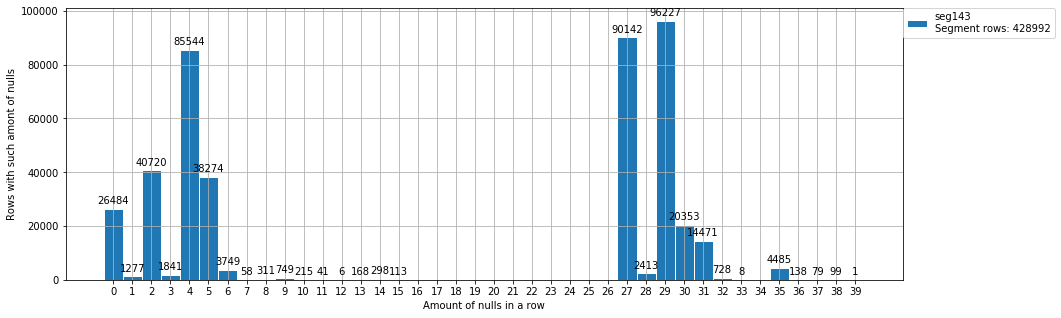

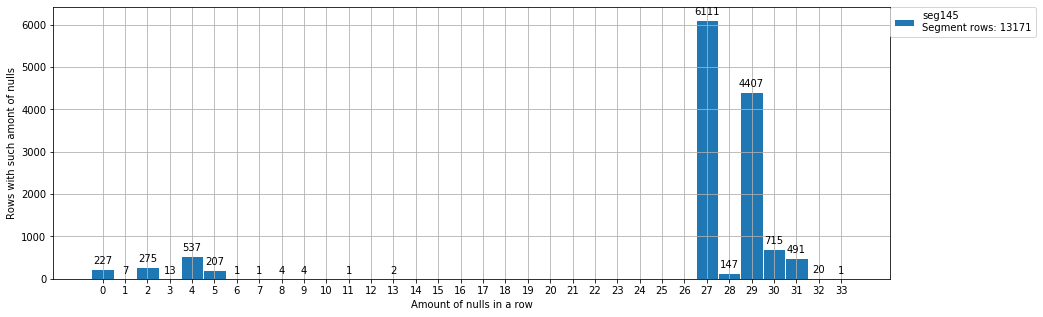

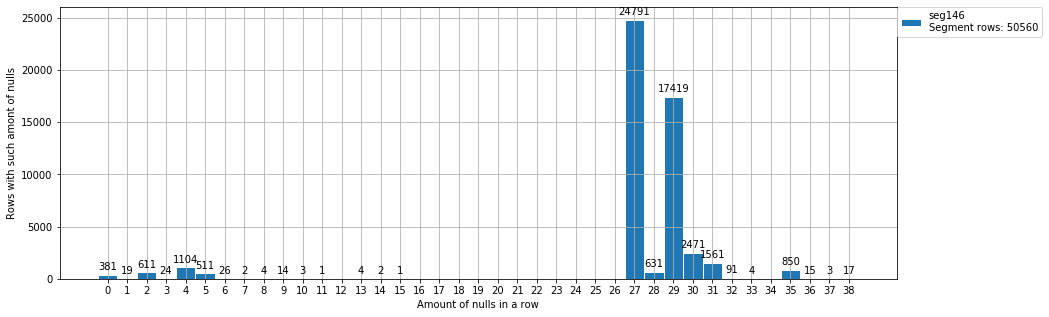

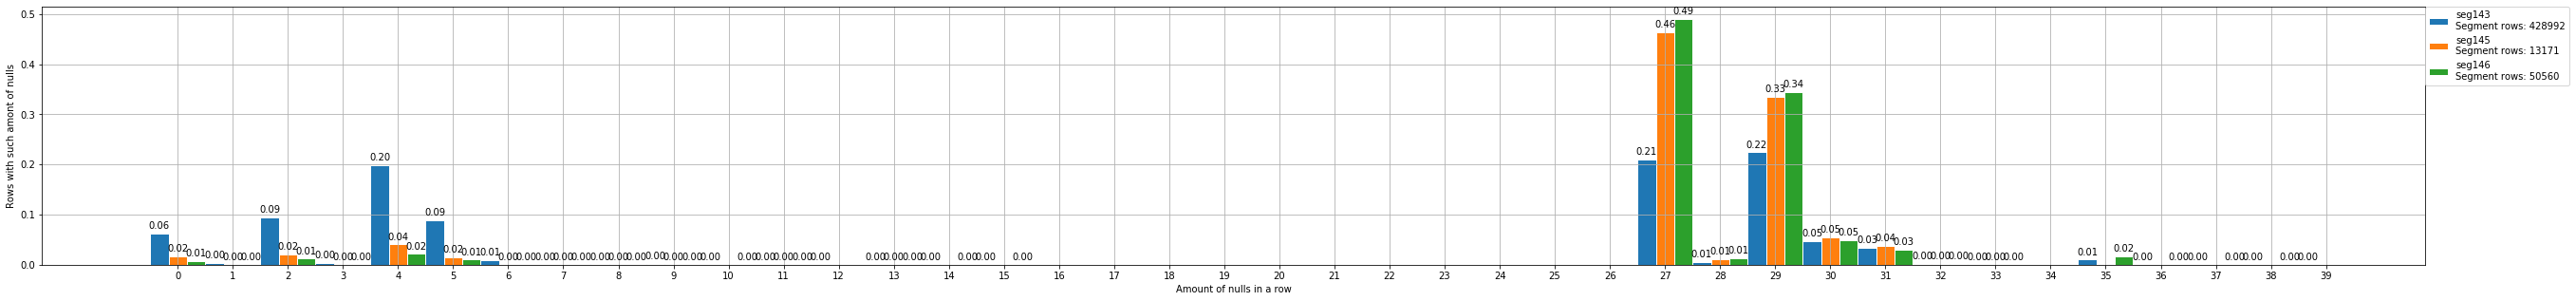

In [52]:
file_names_null_row = [r"data\seg143Nulls-RowsCount.csv",r"data\seg145Nulls-RowsCount.csv",r"data\seg146Nulls-RowsCount.csv"]
file_names_null_count = [r"data\seg143nullCount-percent.txt", r"data\seg145nullCount-percent.txt", r"data\seg146nullCount-percent.txt"]

### ЭТО ДЛЯ СЕТКИ 2х2
# fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,5))

fig, ax1 = plt.subplots(figsize=(15,5))
fig, ax2 = plt.subplots(figsize=(15,5))
fig, ax3 = plt.subplots(figsize=(15,5))
fig, ax4 = plt.subplots(figsize=(45,5))

axs = [ax1,ax2,ax3]
for i in range(len(file_names_null_row)):
    all, _, _ = get_nulls_in_segment(file_names_null_count[i])
    show_plots_for_all_files(axs[i], [file_names_null_row[i]])
    axs[i].legend(["seg" + re.findall('(\d+)', file_names_null_row[i])[0]+"\nSegment rows: "+all],bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

num_to_norm = []
for n in file_names_null_count:
    num_to_norm.append(get_nulls_in_segment(n)[0])
    
show_plots_for_all_files(ax4, file_names_null_row, num_to_norm)
ax4.legend([("seg" + re.findall('(\d+)', file_names_null_row[i])[0]
             +"\nSegment rows: "+get_nulls_in_segment(file_names_null_count[i])[0]) 
            for i in range(len(file_names_null_row))], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()

# 2

In [53]:
file_names_null_count = [r"data\seg143nullCount-percent.txt", r"data\seg145nullCount-percent.txt", r"data\seg146nullCount-percent.txt"]
for name in file_names_null_count:
    all, nulls, percent = get_nulls_in_segment(name)
    print("In segment {}:\n all: {}\n nulls: {}\n percent: {}".format(re.findall('(\d+)', name)[0], all, nulls, percent))

In segment 143:
 all: 428992
 nulls: 402508
 percent: 0.9382645830225272
In segment 145:
 all: 13171
 nulls: 12944
 percent: 0.9827651658947688
In segment 146:
 all: 50560
 nulls: 50179
 percent: 0.9924643987341772


# 3

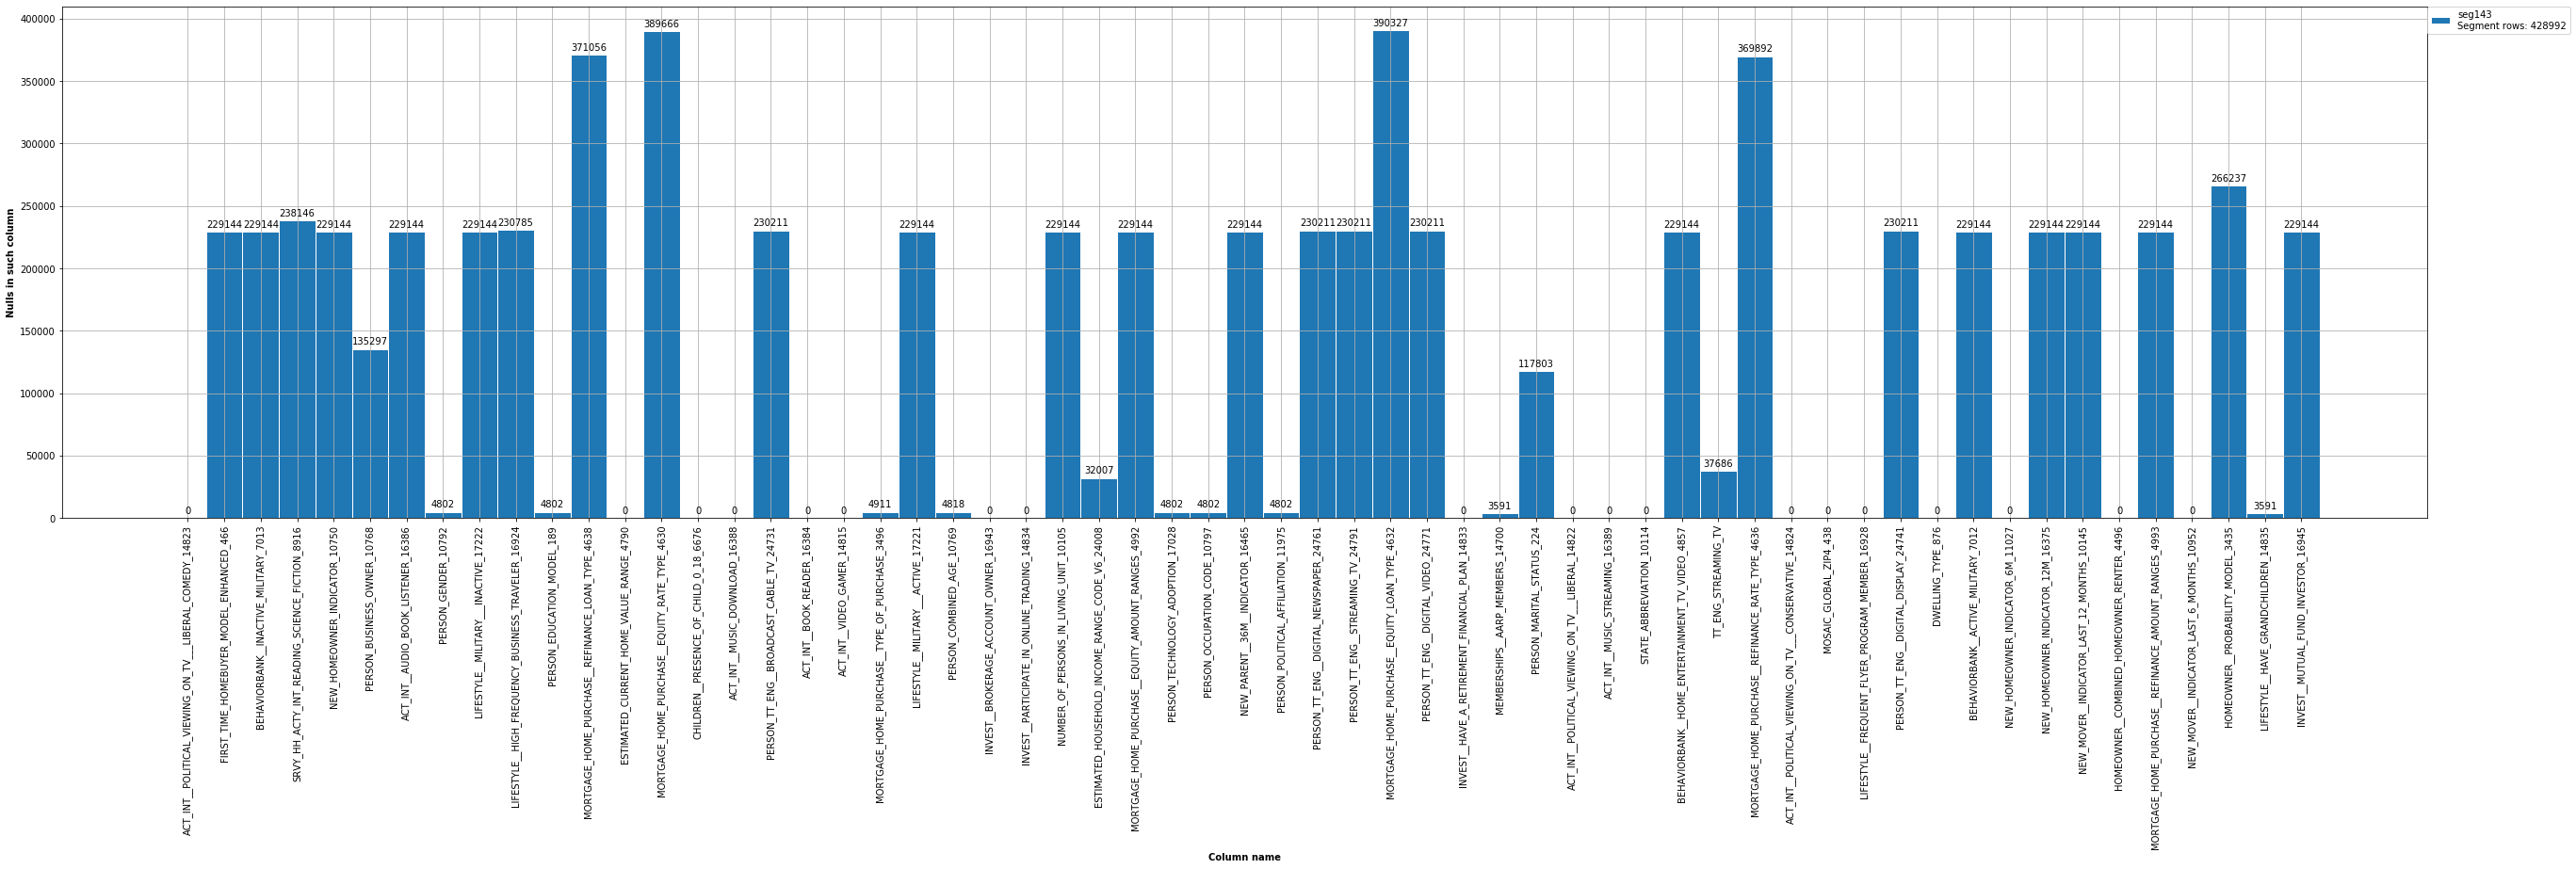

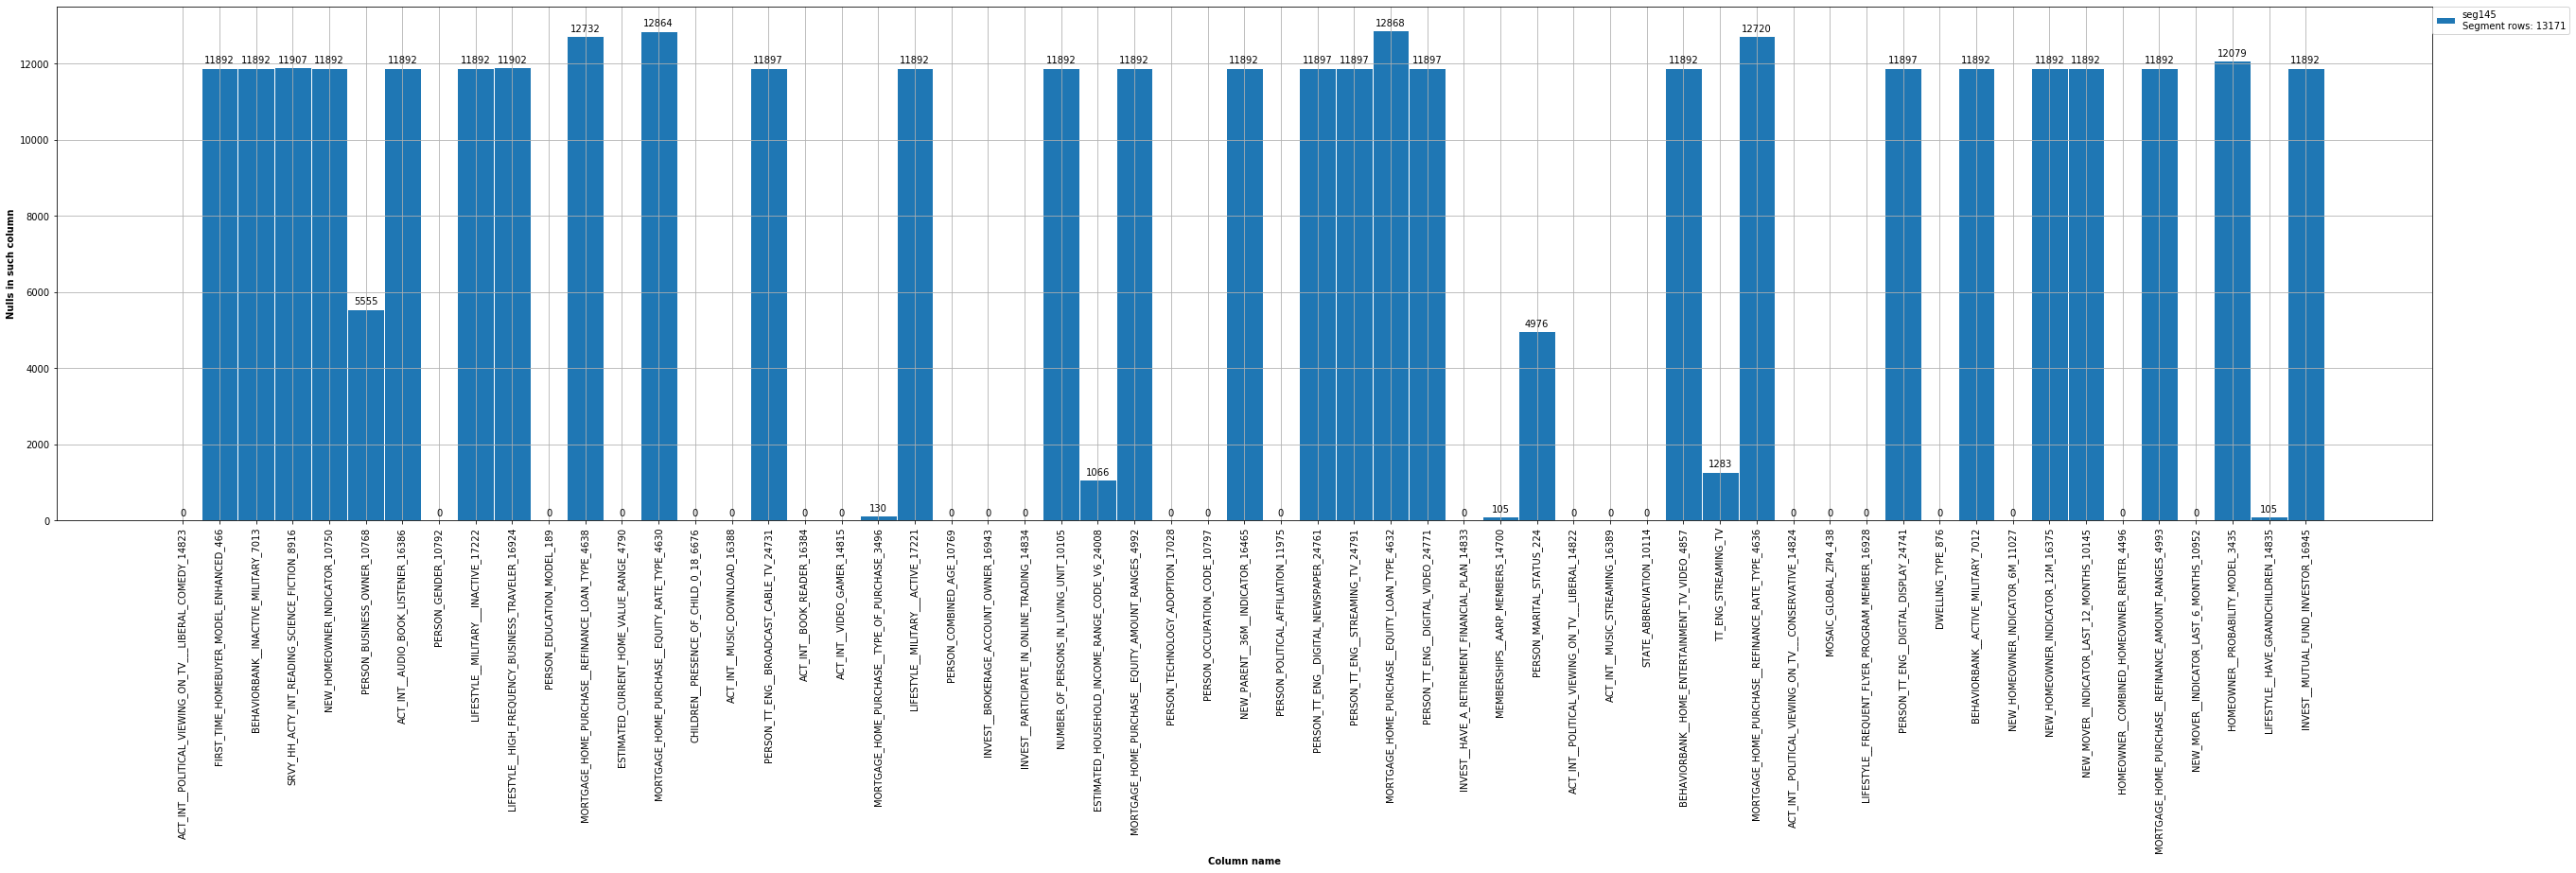

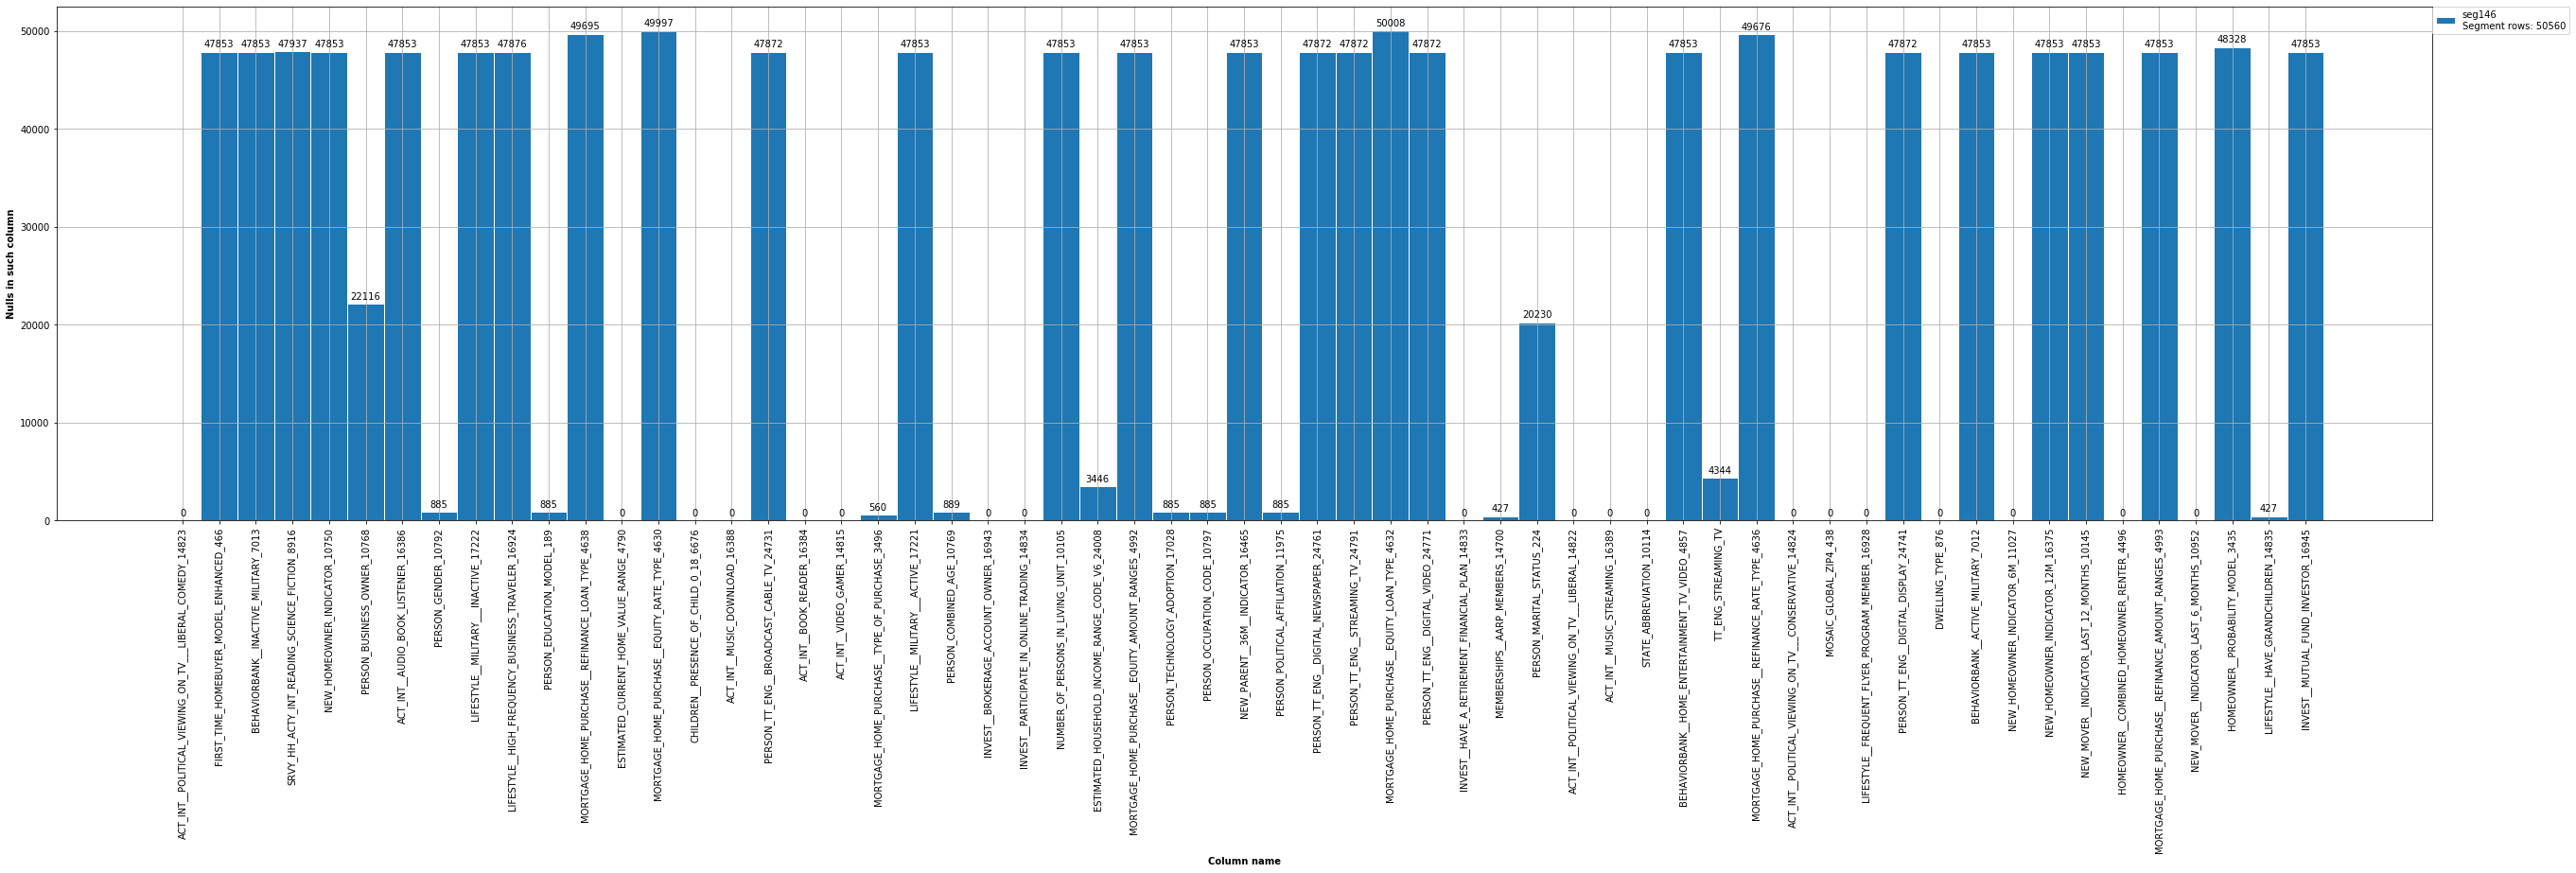

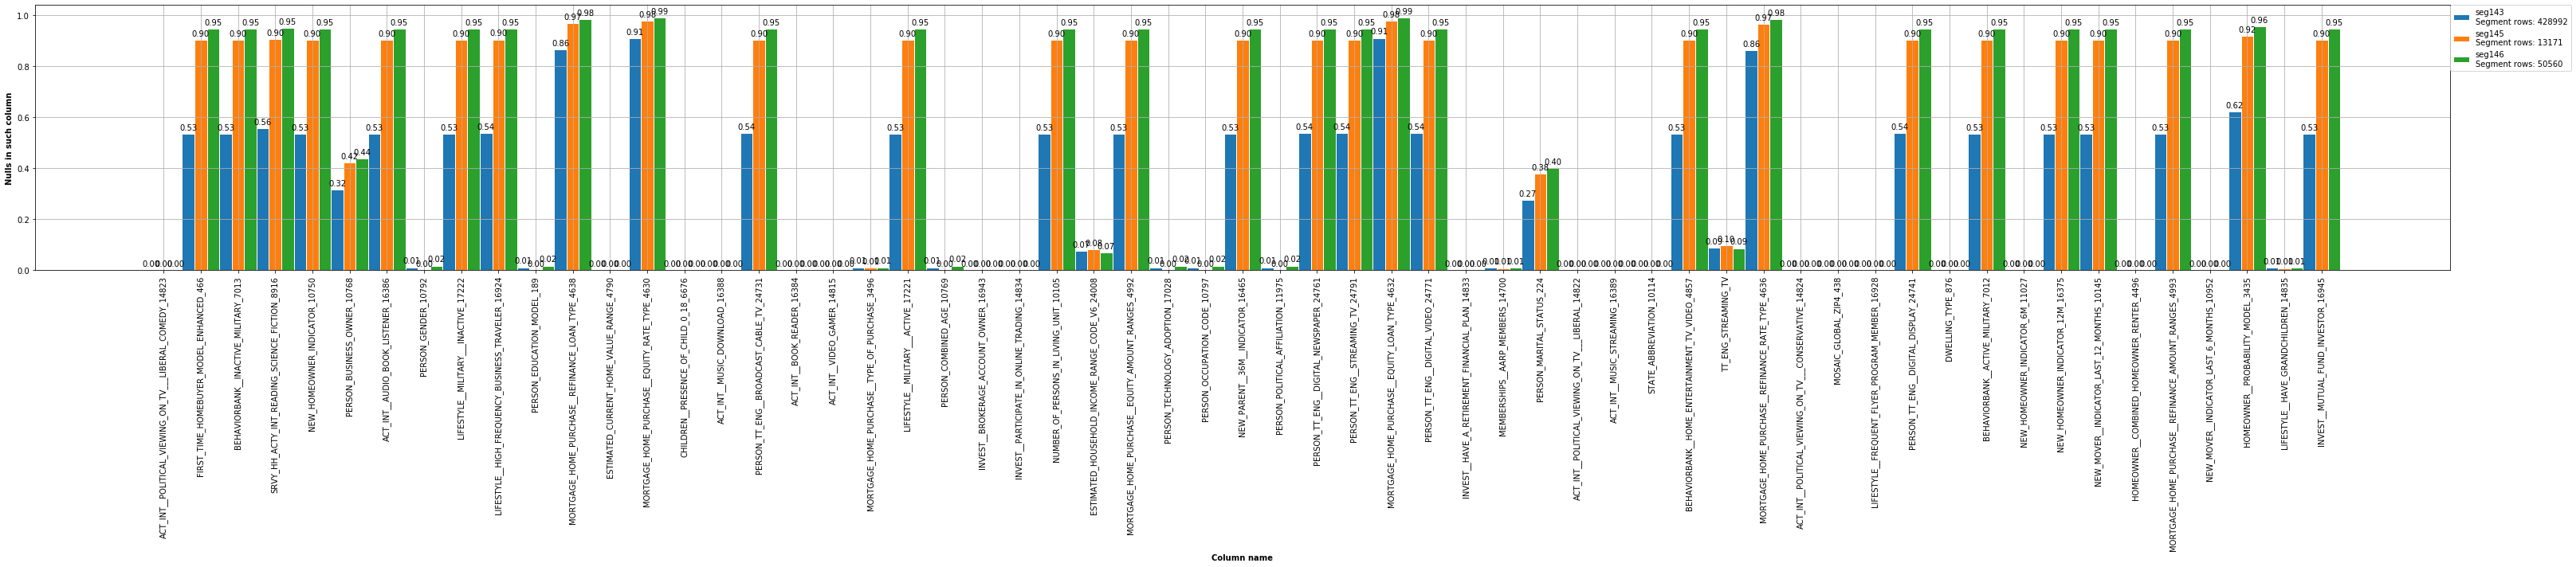

In [54]:
file_names_percent = [r"data\seg143percent.csv",r"data\seg145percent.csv",r"data\seg146percent.csv"]
file_names_amount = [r"data\seg143amount.csv",r"data\seg145amount.csv",r"data\seg146amount.csv"]

file_names_null_count = [r"data\seg143nullCount-percent.txt", r"data\seg145nullCount-percent.txt", r"data\seg146nullCount-percent.txt"]

#Графики только в отдельных, вместе подписи нельзя правильно разместить 
col_names = load_main_column_names(segment_header_file)                

# set width of bar
fig, ax1 = plt.subplots(figsize=(45,10))
fig, ax2 = plt.subplots(figsize=(45,10))
fig, ax3 = plt.subplots(figsize=(45,10))
fig, ax4 = plt.subplots(figsize=(45,10))


axs = [ax1,ax2,ax3]
for i in range(len(file_names_percent)):
    all, _, _ = get_nulls_in_segment(file_names_null_count[i])
    show_plots_for_all_percent_files_bar(axs[i], [file_names_amount[i]], col_names, False)
    axs[i].legend(["seg" + re.findall('(\d+)', file_names_amount[i])[0]+"\nSegment rows: "+all], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

show_plots_for_all_percent_files_bar(ax4, file_names_percent, col_names)
ax4.legend([("seg" + re.findall('(\d+)', file_names_percent[i])[0] 
             +"\nSegment rows: "+get_nulls_in_segment(file_names_null_count[i])[0]) 
            for i in range(len(file_names_percent))], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout()
plt.show()


# 4

In [55]:
def load_main_column_names(col_names_file_name: str) -> List:
    """
    get only important column names
    :param col_names_file_name (str): name of file with column names
    :return: List: list of important column names
    """
    res = open(col_names_file_name, "r").read().splitlines()
    return res[3:]

def load_column_names(col_names_file_name: str) -> List:
    """
    get column names from file
    :param col_names_file_name (str): name of file with column names
    :return: List: list of column names
    """
    res = open(col_names_file_name, "r").read().splitlines()
    return res

def check_column_names(main_column_names: List, column_names_to_check: List) -> List:
    """
    check if column names from main list appear in another list
    :param main_column_names (List): list with main column names
    :param column_names_to_check (List): list with column names to check
    :return: List: list of column names
    """
    res = []
    for n in main_column_names:
        if n in column_names_to_check:
            res.append("+")
        else:
            res.append("")
    return res

In [56]:
col_names = load_main_column_names(segment_header_file)                

col_names_with_null = check_column_names(col_names, load_column_names("seg143HaveNullColumnNames.txt"))       
col_names_with_null_avail = check_column_names(col_names, load_column_names("seg143CanHaveNullColumnNames.txt"))                
col_names_with_unknown = check_column_names(col_names, load_column_names("seg143HaveUnknownColumnNames.txt"))             

print("seg143")
fig = go.Figure(data=[go.Table(columnwidth=[66,11,11,11], header=dict(values=["Column Name","Have empty","Can have empty", "Can have Unknown"]),
                 cells=dict(values=[col_names, col_names_with_null, col_names_with_null_avail, col_names_with_unknown]))
                     ])
fig.show()

seg143


In [57]:
col_names = load_main_column_names(segment_header_file)                

col_names_with_null = check_column_names(col_names, load_column_names("seg145HaveNullColumnNames.txt"))       
col_names_with_null_avail = check_column_names(col_names, load_column_names("seg145CanHaveNullColumnNames.txt"))                
col_names_with_unknown = check_column_names(col_names, load_column_names("seg145HaveUnknownColumnNames.txt"))             

print("seg145")
fig = go.Figure(data=[go.Table(columnwidth=[66,11,11,11], header=dict(values=["Column Name","Have empty","Can have empty", "Can have Unknown"]),
                 cells=dict(values=[col_names, col_names_with_null, col_names_with_null_avail, col_names_with_unknown]))
                     ])
fig.show()

seg145


In [58]:
col_names = load_main_column_names(segment_header_file)                

col_names_with_null = check_column_names(col_names, load_column_names("seg146HaveNullColumnNames.txt"))       
col_names_with_null_avail = check_column_names(col_names, load_column_names("seg146CanHaveNullColumnNames.txt"))                
col_names_with_unknown = check_column_names(col_names, load_column_names("seg146HaveUnknownColumnNames.txt"))             

print("seg146")
fig = go.Figure(data=[go.Table(columnwidth=[66,11,11,11], header=dict(values=["Column Name","Have empty","Can have empty", "Can have Unknown"]),
                 cells=dict(values=[col_names, col_names_with_null, col_names_with_null_avail, col_names_with_unknown]))
                     ])
fig.show()

seg146


In [59]:
!pip freeze > requriments.txt

In [60]:
def get_percent_of_records_with_unknown_for_each_column(segment_df: DataFrame, column_to_check: List = None) -> DataFrame:
    """
    get percent Of Records With Null value for each column
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: dataframe with percent of records with null for each column
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check
    segment_count = segment_df.count()

    col_nulls_proc = segment_df.select(
        [(count(when((col(c) == "Unknown") | (col(c) == "unknown") | (col(c) == r"\Null") | (col(c) == "Unknown ") | (col(c) == "Unknown or not scored"), c)) / segment_count).alias(c) for c in columns])
    return col_nulls_proc

def get_amount_of_records_with_unknown_for_each_column(segment_df: DataFrame, column_to_check: List = None) -> DataFrame:
    """
    get Amount Of Records With Null value for each column
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: dataframe with amount of records with null for each column
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check

    col_nulls = segment_df.select([count(when((col(c) == "Unknown") | (col(c) == "unknown") | (col(c) == r"\Null") | (col(c) == "Unknown ") | (col(c) == "Unknown or not scored"), c)).alias(c) for c in columns])
    return col_nulls

segment_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\EXPERIAN_CONSUMER_VIEW_SEGMENT_143"

col_names = load_main_column_names(segment_header_file)

segment_df = load_data_frame(segment_file, load_header_names(segment_header_file))

get_percent_of_records_with_unknown_for_each_column(segment_df, col_names).coalesce(1).write.save("seg143percentUnk",
                                                                                              format="csv",
                                                                                              delimiter="|")

AnalysisException: 'path file:/C:/Users/User/seg143percentUnk already exists.;'

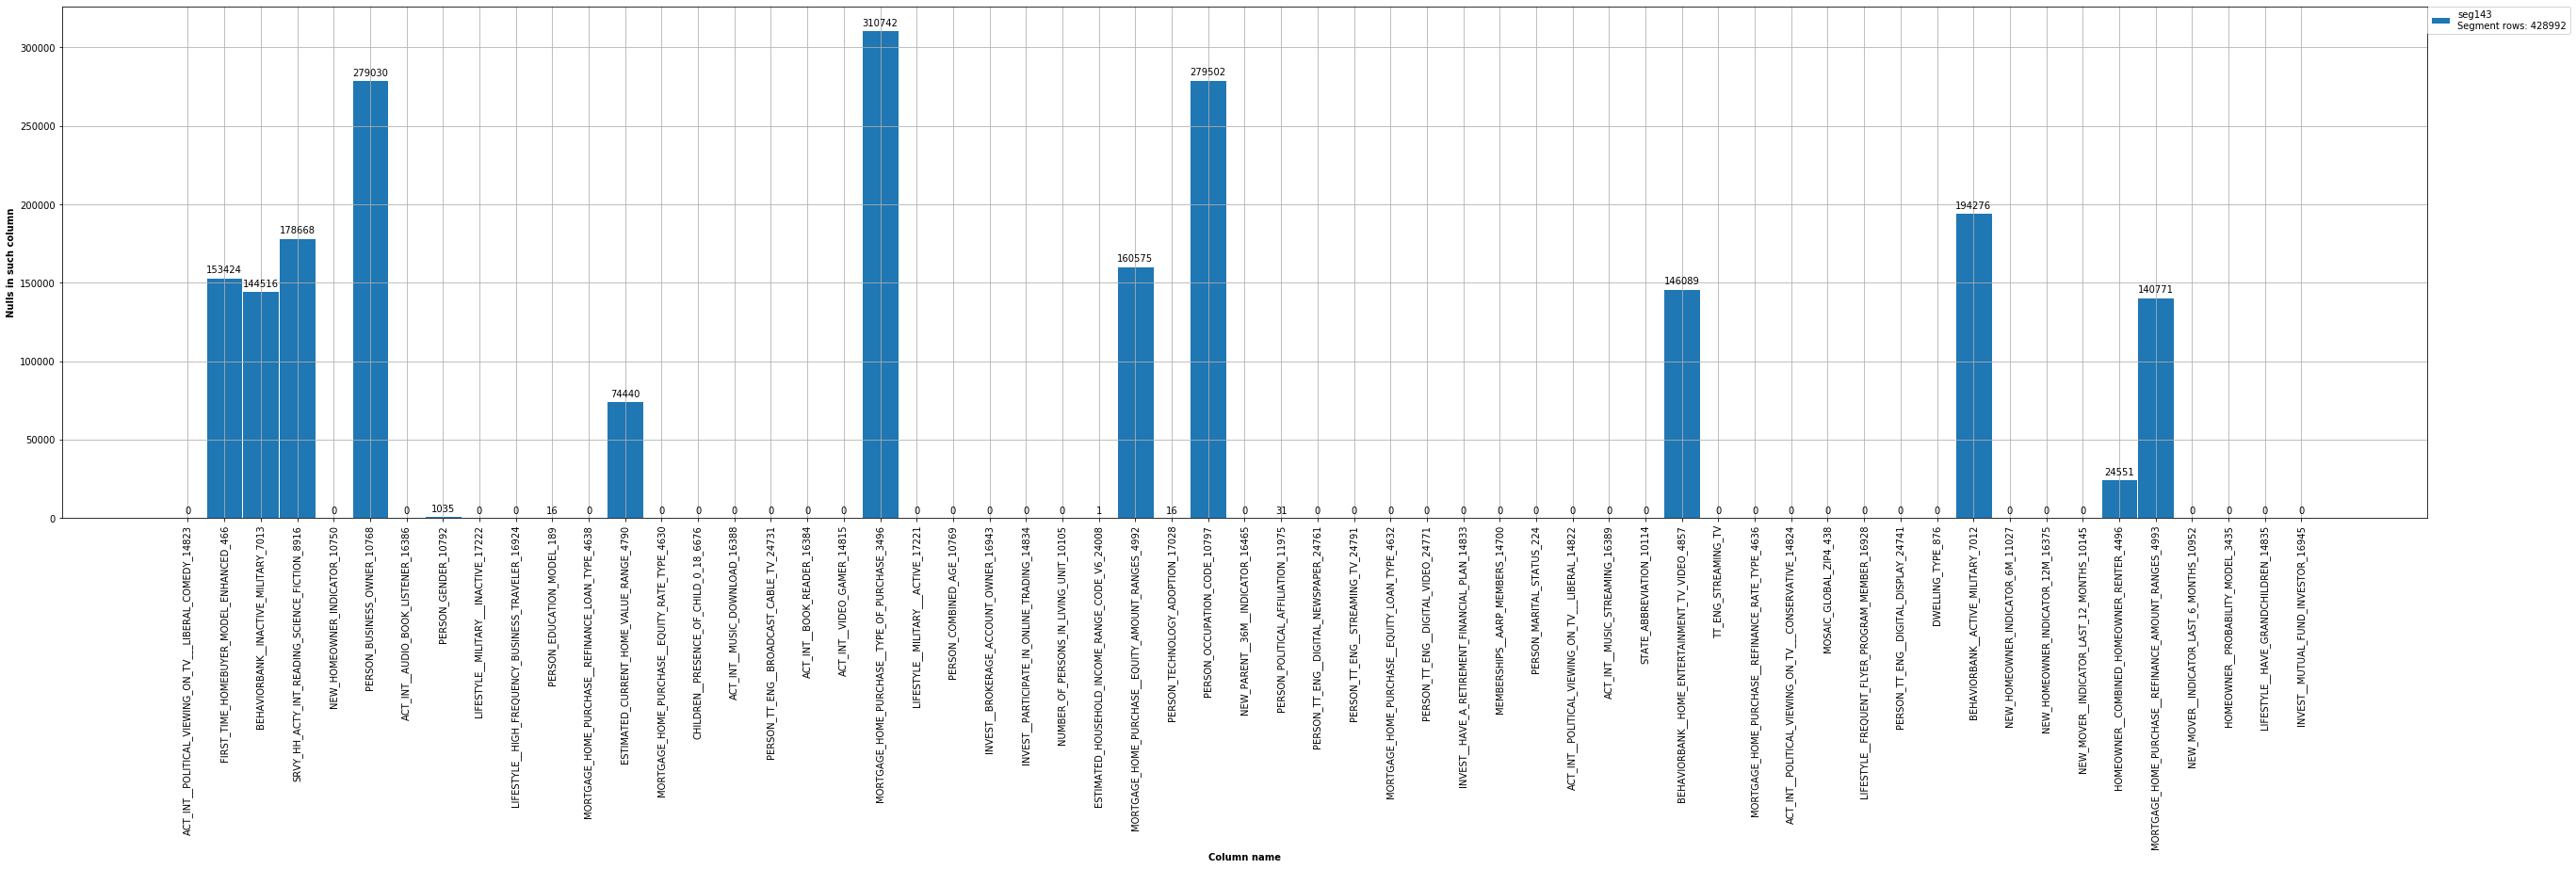

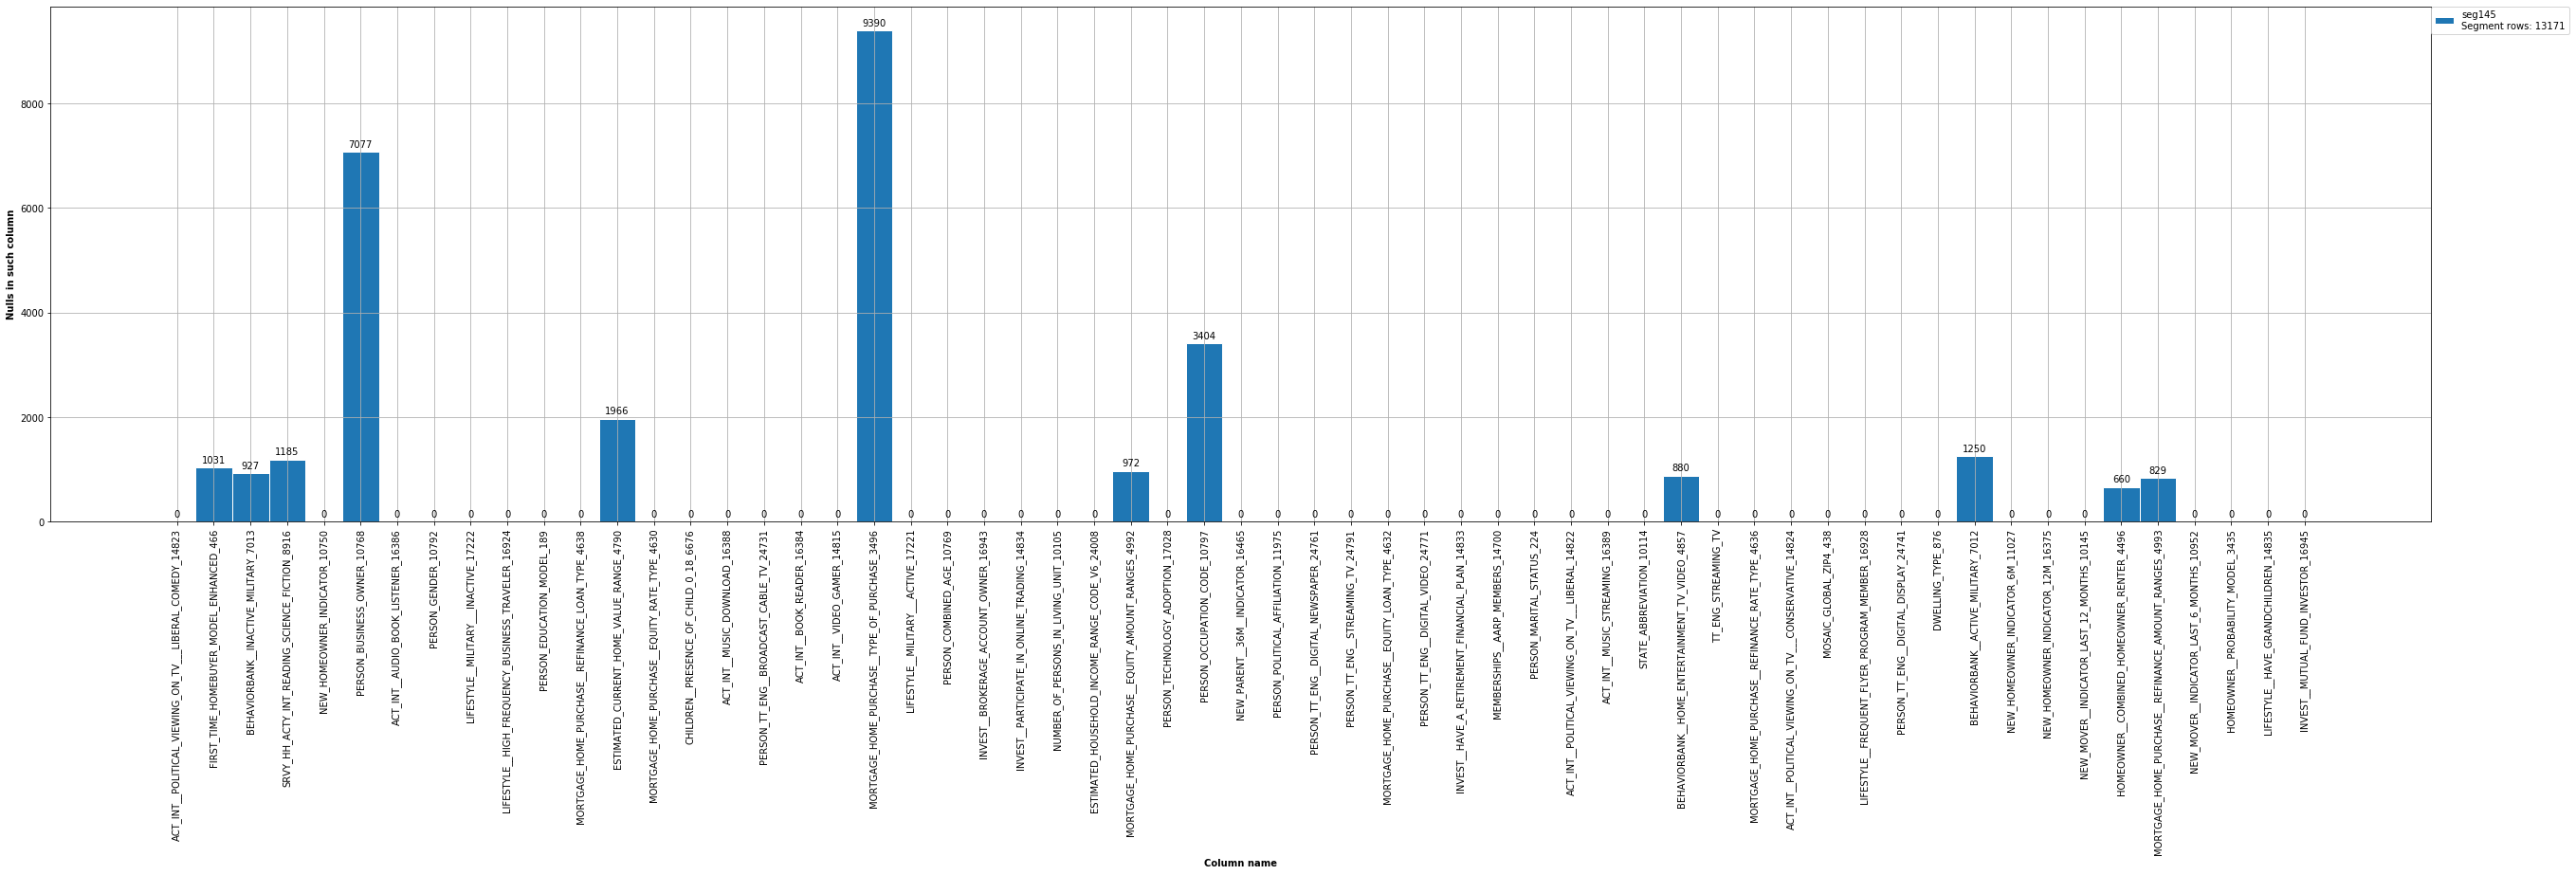

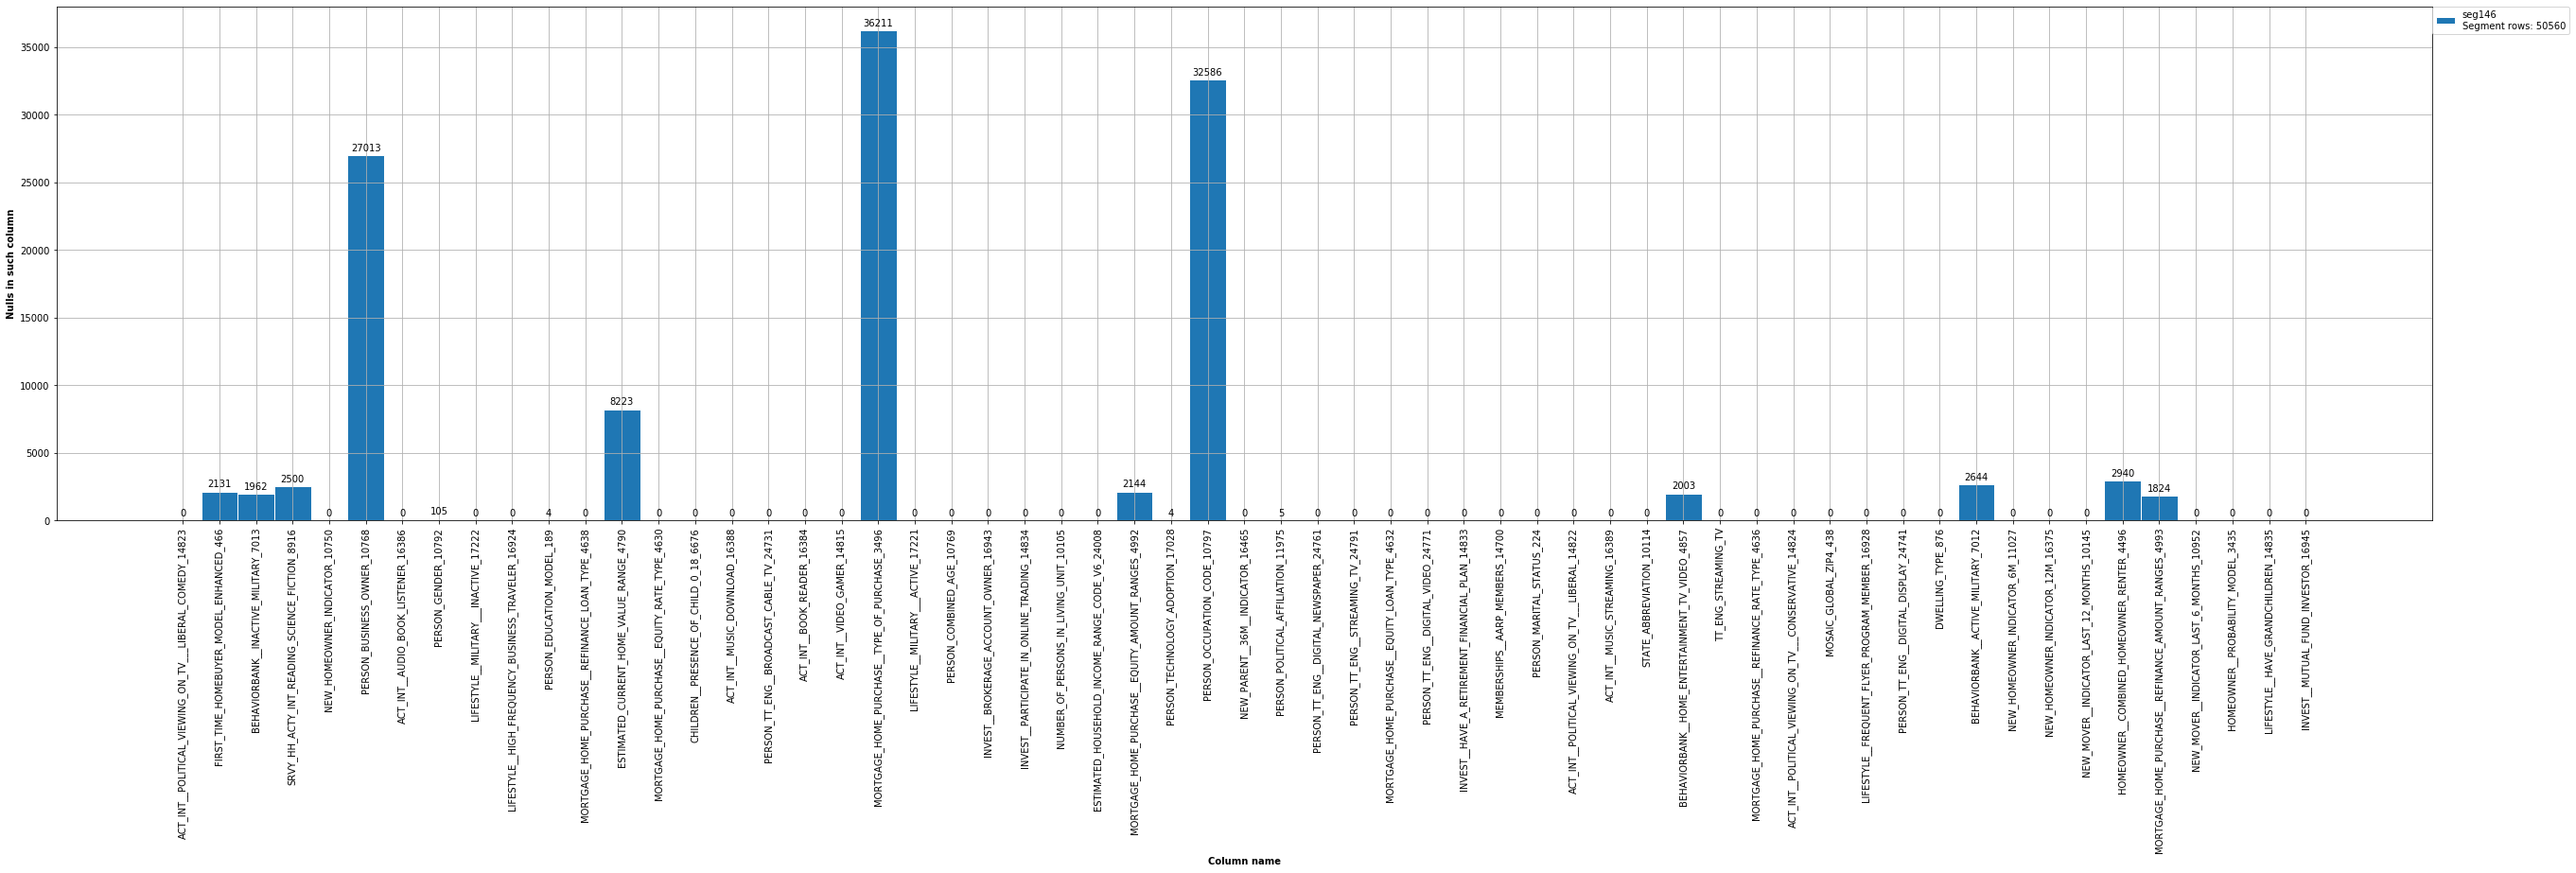

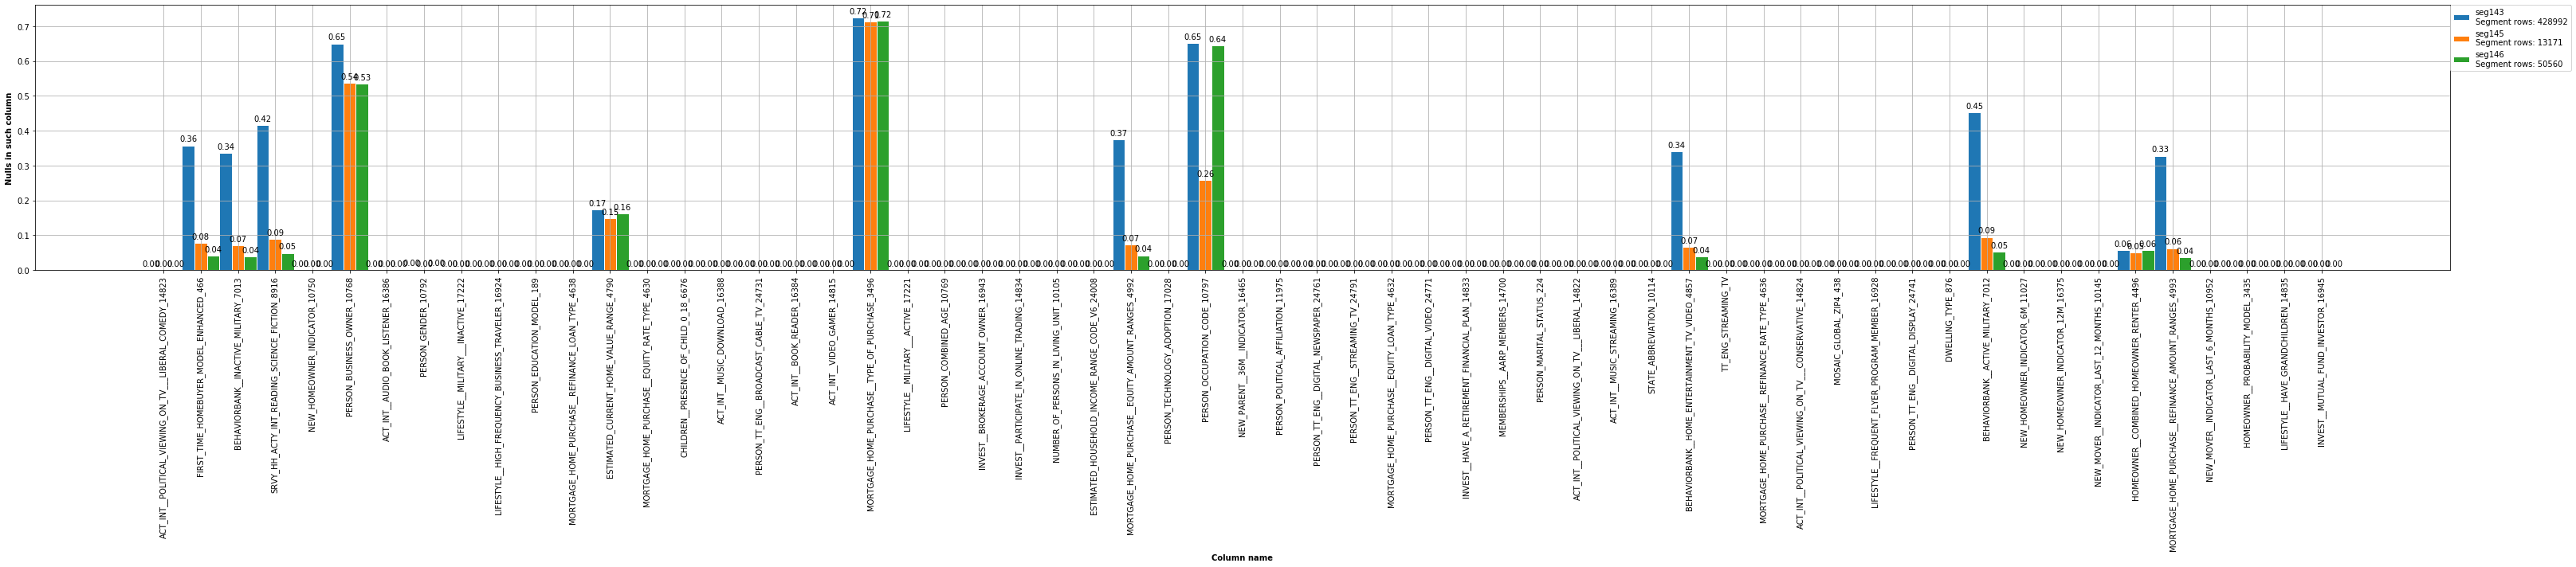

In [62]:
file_names_percent = [r"data\seg143PercentUnknown.csv",r"data\seg145PercentUnknown.csv",r"data\seg146PercentUnknown.csv"]
file_names_amount = [r"data\seg143UnknownAmount.csv",r"data\seg145UnknownAmount.csv",r"data\seg146UnknownAmount.csv"]

file_names_null_count = [r"data\seg143nullCount-percent.txt", r"data\seg145nullCount-percent.txt", r"data\seg146nullCount-percent.txt"]

#Графики только в отдельных, вместе подписи нельзя правильно разместить 
col_names = load_main_column_names(segment_header_file)                

# set width of bar
fig, ax1 = plt.subplots(figsize=(45,10))
fig, ax2 = plt.subplots(figsize=(45,10))
fig, ax3 = plt.subplots(figsize=(45,10))
fig, ax4 = plt.subplots(figsize=(45,10))


axs = [ax1,ax2,ax3]
for i in range(len(file_names_percent)):
    all, _, _ = get_nulls_in_segment(file_names_null_count[i])
    show_plots_for_all_percent_files_bar(axs[i], [file_names_amount[i]], col_names, False)
    axs[i].legend(["seg" + re.findall('(\d+)', file_names_amount[i])[0]+"\nSegment rows: "+all], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

show_plots_for_all_percent_files_bar(ax4, file_names_percent, col_names)
ax4.legend([("seg" + re.findall('(\d+)', file_names_percent[i])[0] 
             +"\nSegment rows: "+get_nulls_in_segment(file_names_null_count[i])[0]) 
            for i in range(len(file_names_percent))], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout()
plt.show()

In [43]:
#OLD 3 WITH DOTS
# file_names_percent = [r"data\seg143percent.csv",r"data\seg145percent.csv",r"data\seg146percent.csv"]
# file_names_null_count = [r"data\seg143nullCount-percent.txt", r"data\seg145nullCount-percent.txt", r"data\seg146nullCount-percent.txt"]

# #Графики только в отдельных, вместе подписи нельзя правильно разместить 
# col_names = load_main_column_names(segment_header_file)                
# fig, ax1 = plt.subplots(figsize=(15,5))
# fig, ax2 = plt.subplots(figsize=(15,5))
# fig, ax3 = plt.subplots(figsize=(15,5))
# fig, ax4 = plt.subplots(figsize=(15,5))

# axs = [ax1,ax2,ax3]
# for i in range(len(file_names_percent)):
#     all, _, _ = get_nulls_in_segment(file_names_null_count[i])
#     show_plots_for_all_percent_files(axs[i], [file_names_percent[i]], col_names)
#     axs[i].legend(["seg" + re.findall('(\d+)', file_names_percent[i])[0]+"\nSegment rows: "+all],bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

# show_plots_for_all_percent_files(ax4, file_names_percent, col_names)
# ax4.legend([("seg" + re.findall('(\d+)', file_names_percent[i])[0]
#              +"\nSegment rows: "+get_nulls_in_segment(file_names_null_count[i])[0]) 
#             for i in range(len(file_names_percent))], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
           
# fig.tight_layout()
# plt.show()